# Get Data and Visualize

In [1]:
# import numpy, pandas for data manipulation
import numpy as np
import pandas as pd

# import matplotlib, seabron
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import data
weather_data = pd.read_csv('../Project-2 Code/nyc_weather_data_2015-2021.csv', parse_dates=['Date'])

# Check Dataset shape
print(weather_data.shape)

# select the data and temperature columns
temp_df = weather_data[['Date', 'max_temp']]

# rename column
temp_df = temp_df.rename(columns={'max_temp':'avg_temp'})

temp_df.head(10)

(2071, 2)


,Date,avg_temp
0,2015-09-03,33.9
1,2015-09-04,29.4
2,2015-09-05,28.3
3,2015-09-06,30.6
4,2015-09-07,33.3
5,2015-09-08,36.1
6,2015-09-09,32.2
7,2015-09-10,26.1
8,2015-09-11,27.2
9,2015-09-12,26.1


In [3]:
# select the subset datea from 2015 - 2019
mask = (temp_df['Date'] >= '2018-01-01') & (temp_df['Date'] <= '2021-05-04')
temp_df = temp_df.loc[mask]

# reset index
temp_df.set_index('Date', inplace=True)

# iunpect first 5 rows and loast 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,avg_temp
Date,
2018-01-01,-7.1
2018-01-02,-3.2
2018-01-03,-1.0
2018-01-04,-1.6
2018-01-05,-7.1


,avg_temp
Date,
2021-04-30,21.7
2021-05-01,18.3
2021-05-02,27.8
2021-05-03,18.9
2021-05-04,22.8


In [4]:
# describe
temp_df.describe()

,avg_temp
count,1220.000000
mean,16.588689
std,9.906462
min,-10.500000
25%,8.300000
50%,16.700000
75%,25.000000
max,35.600000


In [5]:
# Output the max and min temps
print(temp_df.loc[temp_df['avg_temp'] == temp_df['avg_temp'].max()])
print(temp_df.loc[temp_df['avg_temp'] == temp_df['avg_temp'].min()])

            avg_temp
Date                
2018-07-01      35.6
2020-07-06      35.6
            avg_temp
Date                
2018-01-06     -10.5


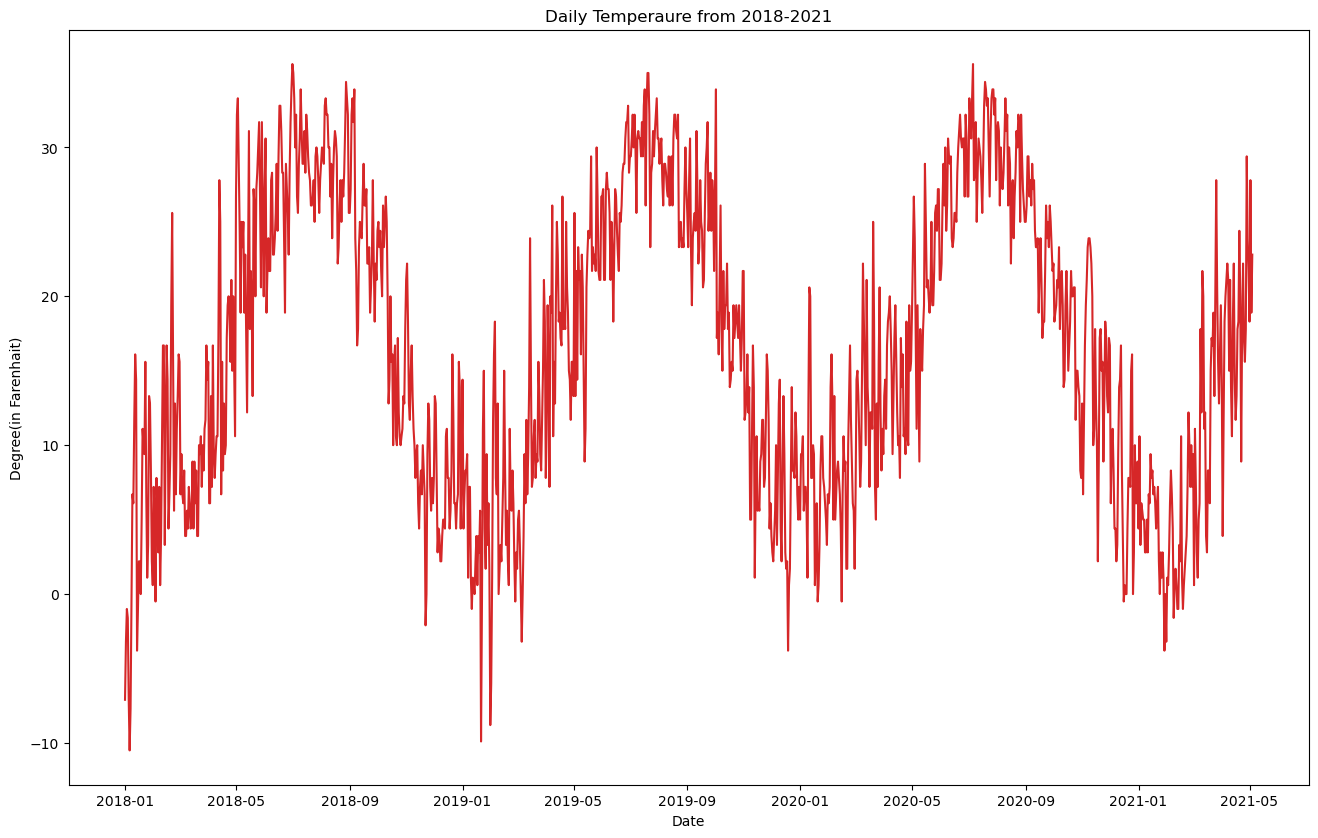

In [6]:
# plot the daily temperature change
plt.figure(figsize=(16,10), dpi=100)
plt.plot(temp_df.index, temp_df.avg_temp, color='tab:red')
plt.gca().set(title='Daily Temperaure from 2018-2021', xlabel='Date', ylabel='Degree(in Farenhait)')
plt.show()

<AxesSubplot:xlabel='Date'>

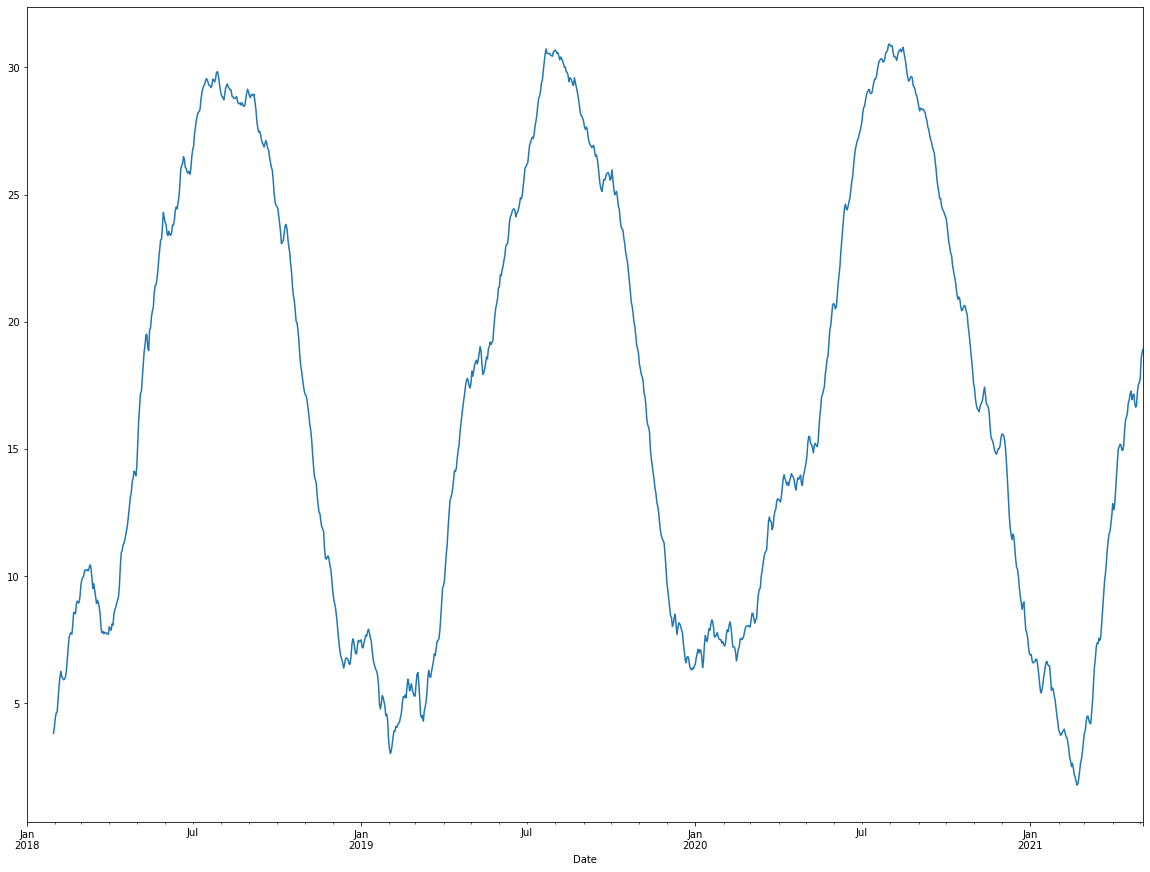

In [7]:
# Apply the moving Average function by a subset of size 30 days
temp_df_mean = temp_df.avg_temp.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

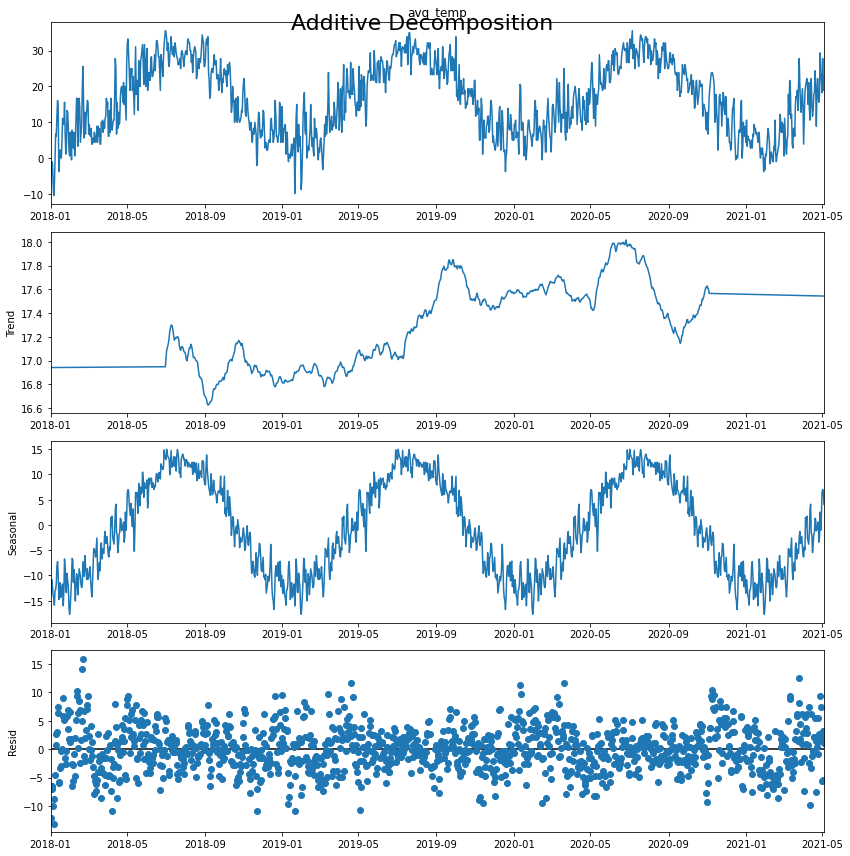

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df.avg_temp, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize':(12,12)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

# Baseline Model
predict the weather based on an assumption. The air temperature today depends on the air temperature yesterday, the air temperature yesterday depends on the day before yesterday, and so on.

In [9]:
# Shift the current temperature to the next day
predicted_df = temp_df['avg_temp'].to_frame().shift(1).rename(columns={'avg_temp':'avg_temp_pred'})
actual_df = temp_df['avg_temp'].to_frame().rename(columns={'avg_temp':'avg_temp_actual'})

# concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df], axis=1)

# Select from the second row because there is no predictions for today due to the shifting/
one_step_df = one_step_df[1:]
one_step_df.head(10)

,avg_temp_actual,avg_temp_pred
Date,,
2018-01-02,-3.2,-7.1
2018-01-03,-1.0,-3.2
2018-01-04,-1.6,-1.0
2018-01-05,-7.1,-1.6
2018-01-06,-10.5,-7.1
2018-01-07,-7.7,-10.5
2018-01-08,-0.5,-7.7
2018-01-09,6.7,-0.5
2018-01-10,6.1,6.7


In [10]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# calculate the RMSE
temp_pred_err = sqrt(MSE(one_step_df.avg_temp_actual, one_step_df.avg_temp_pred))
print('The RMSE is',temp_pred_err)

The RMSE is 4.498887839961622


the RMSE is a little high. Meaning the predictions will be of by 4 degrees C. This is acceptable in weather forecasting since there are many other factors that affect the temperature.

# SARIMA Model

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [11]:
import itertools

# define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Geneerate all different combinations of p, b and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all differenT combincations of season p, b, and q triplets
seasonal_pdq = [(x[0], x[1],x[2], 23) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 23)
SARIMAX: (0, 0, 1) x (0, 1, 0, 23)
SARIMAX: (0, 0, 1) x (0, 1, 1, 23)
SARIMAX: (0, 0, 1) x (1, 0, 0, 23)


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. We are interested in finding the model that yields the lower AIC value

In [12]:
import warnings
warnings.filterwarnings('ignore') 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(one_step_df.avg_temp_actual,
                                              order = param,
                                              seasonal_order = param_seasonal,
                                              enforce_stationarity = False,
                                              enforce_invertibility = False)
            results = model.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# Fit the Model

In [13]:
# import the statsmodel library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
model = sm.tsa.statespace.SARIMAX(one_step_df.avg_temp_actual,
                                  order = (1,1,1),
                                  season_order = (1,1,1,12),
                                  enforce_stationarity = False,
                                  enforce_inertability = False)
results = model.fit()

# Model Diagnostics

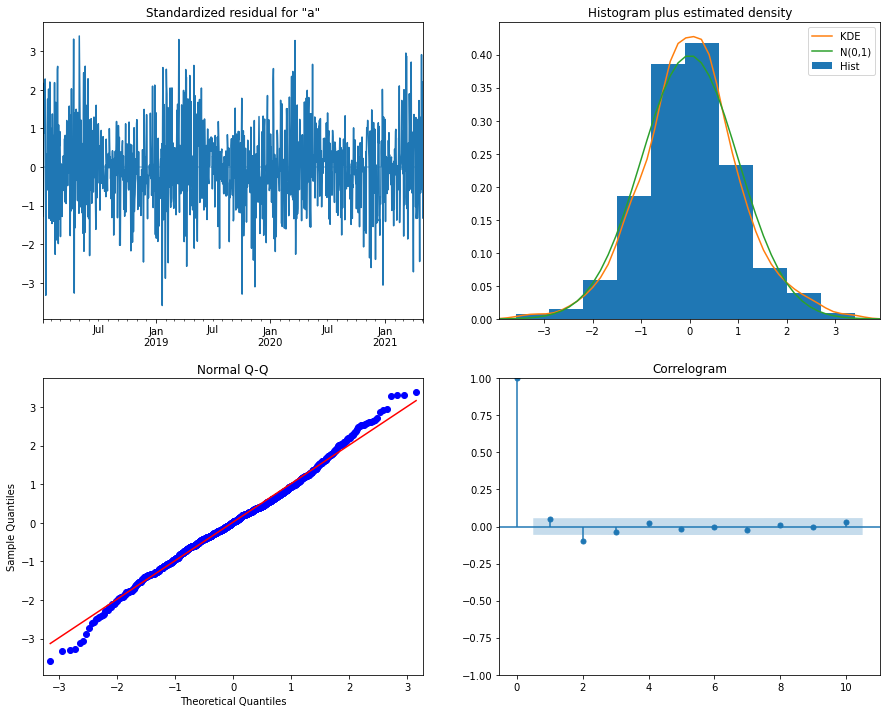

In [14]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

we want to ensure that the residuals of our models are uncorrelated and normally distributed with zero-mean. If the SARIMA model does not satisfy these properties, it's a good indication that it can be further imporved.

- the histogram shows us the orange KDE line follows closely with the N(0,1) line. The N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. this graph indicates that the residual are normaly distributed.


- the bottom left plot (Q-Q plot) shows us that the ordered distribution of the residuals closely follows the linear trend taken from a standard normal distribution with N(0,1). this is shows a strong indication that the residuals are normally distributed.


- the top left plot shows residuals over time and it does not diplay any obvious seasonality, as it seems to just be noise. this is confirmed by the correlogram (bottom right plot), which tells us that the time series residuals have low correlation with lagged versions of itself


With these observations, we can conclude that our model produces a very statisfactory fit that could help us understand our time series data and forecast future values.

# Validating Non-Dynamic Forecast

The get_predcition() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series

In [15]:
# set forecast to start at 2029-06-15
pred = results.get_prediction(start=pd.to_datetime('2019-06-05'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci

,lower avg_temp_actual,upper avg_temp_actual
2019-06-05,14.137160,30.108872
2019-06-06,17.579541,33.551252
2019-06-07,18.414863,34.386574
2019-06-08,17.996371,33.968083
2019-06-09,18.140011,34.111722
...,...,...
2021-04-30,13.735317,29.707029
2021-05-01,12.707282,28.678993
2021-05-02,10.840083,26.811794
2021-05-03,16.327056,32.298767


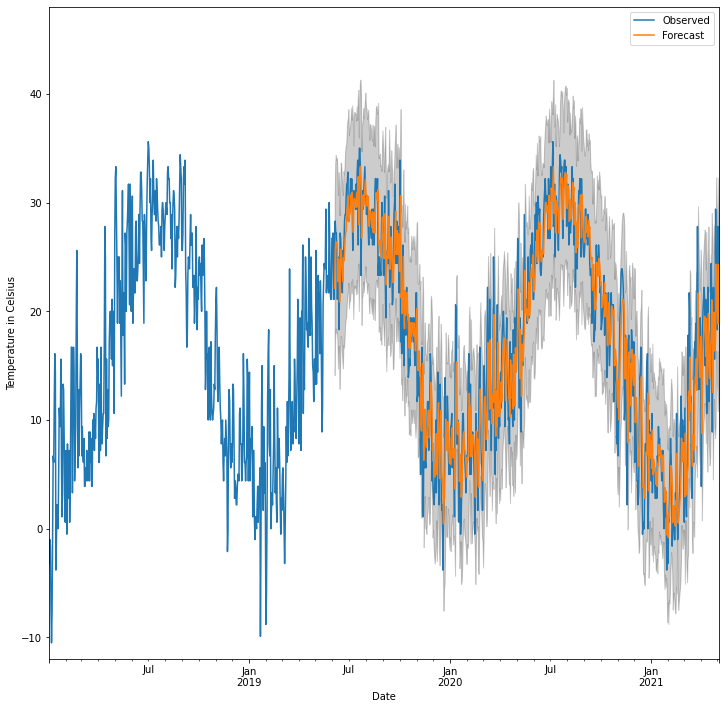

In [16]:
ax = one_step_df.avg_temp_actual['2015':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in Celsius')
plt.ylim([-12,48])
plt.legend()
plt.show()

*insert obervation here when showing graph correctly*

# Non-Dynamic Forecast Diagnostic

In [17]:
# Extract the predicted and true values of our time series

y_forecasted = pred.predicted_mean
y_actual = one_step_df.avg_temp_actual['2019-06-05':]
print(y_forecasted.shape)
print(y_actual.shape)

# calculate the MSE
mse = MSE(y_actual, y_forecasted, squared=True)
print('The MSE is',round(mse,2))

(700,)
(700,)
The MSE is 14.33


This is ridiculouly high, and is not a very good predictor whatsoever

# Validating Dynamic Forecast

In [18]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2019-06-05'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

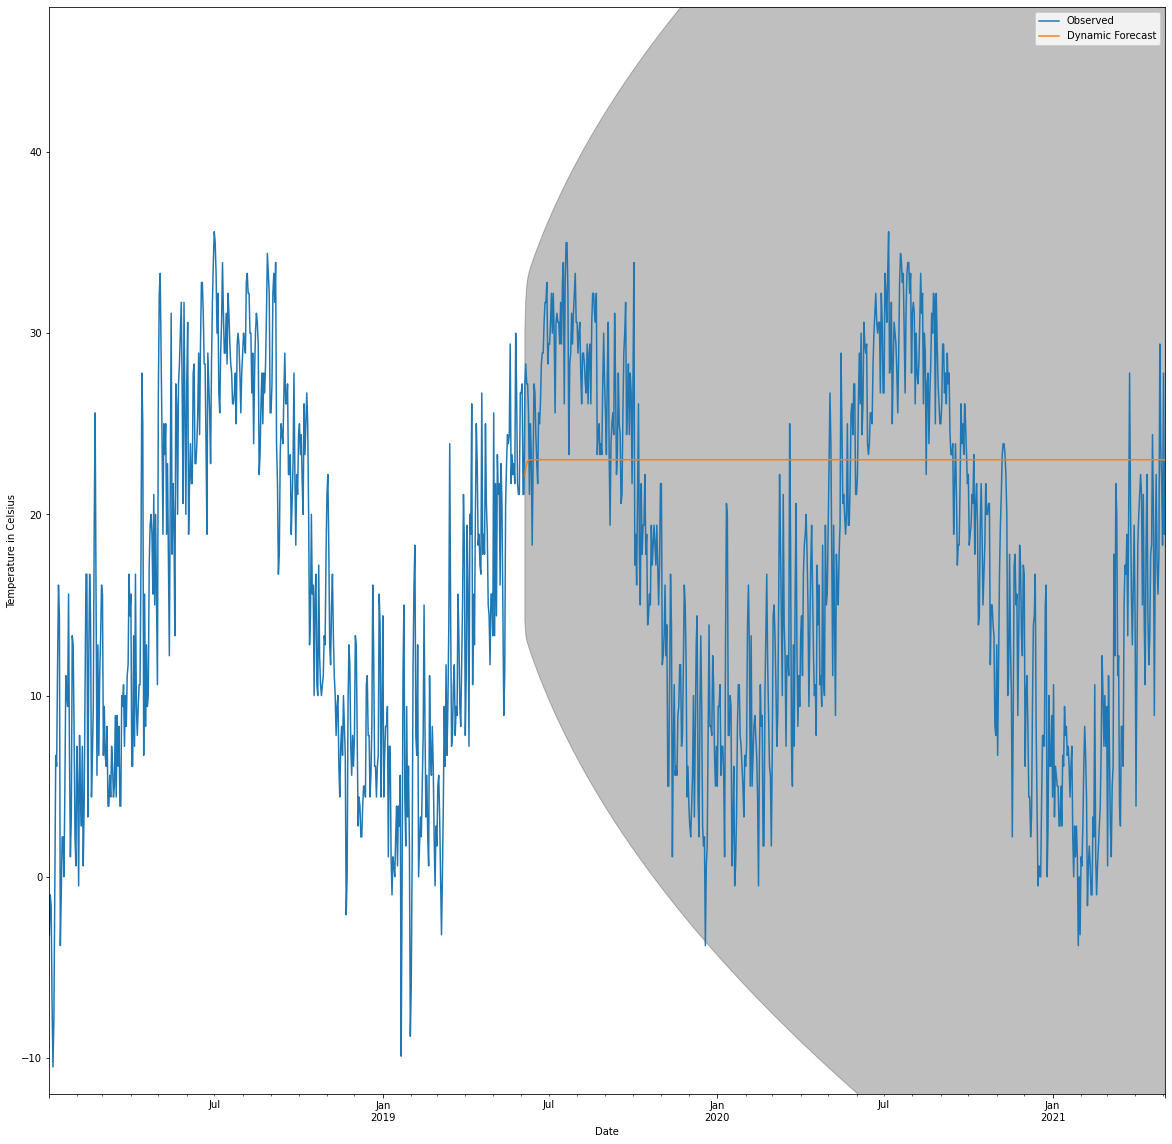

In [19]:
# plot the real and forecasted values of the average daily temperature to assess how well we did

ax = one_step_df.avg_temp_actual['2015':].plot(label='Observed', figsize=(20,20))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in Celsius')
plt.ylim([-12,48])
plt.legend()
plt.show()

This model does not seem to predict the temperature accuratly. NEEDS WORK!!

# Dynamic Forecast Diagnostics

In [20]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_actual = one_step_df.avg_temp_actual['2019-06-05':]

# Calculate MSE
mse = sqrt(MSE(y_actual, y_forecasted).mean())
print('The RMSE is',round(mse,2))

The RMSE is 11.22


The MSE for the Dynamic Forcase dropped Significantly!! 